In [1]:
import os
import sys; sys.path.append("~/HHbbgg_ETH/Training/python") # to load packages
import training_utils as utils
import numpy as np
reload(utils)

Welcome to ROOTaaS 6.05/02


/swshare/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/swshare/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


<module 'training_utils' from '/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/Training/python/training_utils.pyc'>

In [3]:
ntuples = '20170526'
# "%" sign allows to interpret the rest as a system command
%env data=$utils.IO.ldata$ntuples
files = ! ls $data | sort -t_ -k 3 -n
signal = [s for s in files if "NonRes" in s]
diphotonJets = [s for s in files if "DiPhotonJets" in s]
gJets_lowPt = [s for s in files if "GJet_Pt-20to40" in s]
gJets_highPt = [s for s in files if "GJet_Pt-40" in s]

utils.IO.add_signal(ntuples,signal,1)
utils.IO.add_background(ntuples,diphotonJets,-1)
utils.IO.add_background(ntuples,gJets_lowPt,-2)
utils.IO.add_background(ntuples,gJets_highPt,-2)

for i in range(len(utils.IO.backgroundName)):        
    print "using background file n."+str(i)+": "+utils.IO.backgroundName[i]
for i in range(len(utils.IO.signalName)):    
    print "using signal file n."+str(i)+": "+utils.IO.signalName[i]

env: data=/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170526
using background file n.0: /mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170526/output_DiPhotonJetsBox_MGG-80toInf_13TeV-Sherpa.root
using background file n.1: /mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170526/output_GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8.root
using background file n.2: /mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170526/output_GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8.root
using signal file n.0: /mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170526/AllNonResSig_20170526.root


In [4]:
#use noexpand for root expressions, it needs this file https://github.com/ibab/root_pandas/blob/master/root_pandas/readwrite.py
branch_names = 'leadingJet_bDis,subleadingJet_bDis,noexpand:fabs(CosThetaStar_CS),noexpand:fabs(CosTheta_bb),noexpand:fabs(CosTheta_gg),noexpand:diphotonCandidate.Pt()/diHiggsCandidate.M(),noexpand:dijetCandidate.Pt()/diHiggsCandidate.M(),customLeadingPhotonIDMVA,customSubLeadingPhotonIDMVA,leadingPhotonSigOverE,subleadingPhotonSigOverE,sigmaMOverMDecorr,noexpand:sqrt((diphotonCandidate.Eta()-dijetCandidate.Eta())*(diphotonCandidate.Eta()-dijetCandidate.Eta())+TVector2::Phi_mpi_pi(subleadingPhoton.Phi()-dijetCandidate.Phi())*TVector2::Phi_mpi_pi(diphotonCandidate.Phi()-dijetCandidate.Phi()))'.split(",")
#branch_names = 'leadingJet_bDis,subleadingJet_bDis,noexpand:fabs(CosThetaStar_CS),noexpand:fabs(CosTheta_bb),noexpand:fabs(CosTheta_gg),noexpand:diphotonCandidate.Pt()/diHiggsCandidate.M(),noexpand:dijetCandidate.Pt()/diHiggsCandidate.M()'.split(",")
branch_names = [c.strip() for c in branch_names]
#branch_names = (b.replace(" ", "_") for b in branch_names)
#branch_names = list(b.replace("-", "_") for b in branch_names)
print branch_names

import pandas as pd
import root_pandas as rpd

#utils.IO.get_cross_sections('jsons/datasets80X_Moriond.json')
#utils.IO.w_sig.append(utils.IO.get_weight('signal','nrSM',0))
#utils.IO.w_bkg(utils.IO.get_weight('background','DiPhoJets',0))
#utils.IO.w_bkg(utils.IO.get_weight('background','GJets',0))
#utils.IO.w_bkg(utils.IO.get_weight('background','GJets',1))


utils.preprocessing.set_signals_and_backgrounds("bbggSelectionTree",branch_names)
X_bkg,y_bkg,weights_bkg,X_sig,y_sig,weights_sig=utils.preprocessing.set_variables(branch_names)

#relative weighting between components of one class is kept, all classes normalized to the same
weights_bkg,weights_sig=utils.preprocessing.normalize_process_weights(weights_bkg,y_bkg,weights_sig,y_sig)

X_bkg,y_bkg,weights_bkg = utils.preprocessing.randomize(X_bkg,y_bkg,weights_bkg)
X_sig,y_sig,weights_sig = utils.preprocessing.randomize(X_sig,y_sig,weights_sig)


y_total_train = utils.preprocessing.get_total_training_sample(y_sig,y_bkg).ravel()
X_total_train = utils.preprocessing.get_total_training_sample(X_sig,X_bkg)

y_total_test = utils.preprocessing.get_total_test_sample(y_sig,y_bkg).ravel()
X_total_test = utils.preprocessing.get_total_test_sample(X_sig,X_bkg)

w_total_train = utils.preprocessing.get_total_training_sample(weights_sig,weights_bkg).ravel()
w_total_test = utils.preprocessing.get_total_test_sample(weights_sig,weights_bkg).ravel()

['leadingJet_bDis', 'subleadingJet_bDis', 'noexpand:fabs(CosThetaStar_CS)', 'noexpand:fabs(CosTheta_bb)', 'noexpand:fabs(CosTheta_gg)', 'noexpand:diphotonCandidate.Pt()/diHiggsCandidate.M()', 'noexpand:dijetCandidate.Pt()/diHiggsCandidate.M()', 'customLeadingPhotonIDMVA', 'customSubLeadingPhotonIDMVA', 'leadingPhotonSigOverE', 'subleadingPhotonSigOverE', 'sigmaMOverMDecorr', 'noexpand:sqrt((diphotonCandidate.Eta()-dijetCandidate.Eta())*(diphotonCandidate.Eta()-dijetCandidate.Eta())+TVector2::Phi_mpi_pi(subleadingPhoton.Phi()-dijetCandidate.Phi())*TVector2::Phi_mpi_pi(diphotonCandidate.Phi()-dijetCandidate.Phi()))']


In [5]:
import xgboost as xgb
#FIXME parameteres
clf = xgb.XGBClassifier(max_depth=10,learning_rate=0.2,n_estimators=500, min_child_weight=1e-5, nthread= 12)
#clf = xgb.XGBClassifier(max_depth=5,learning_rate=0.2,n_estimators=100, min_child_weight=1e-5, nthread= 12)
clf.fit(X_total_train,y_total_train, sample_weight=w_total_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=10,
       min_child_weight=1e-05, missing=None, n_estimators=500, nthread=12,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

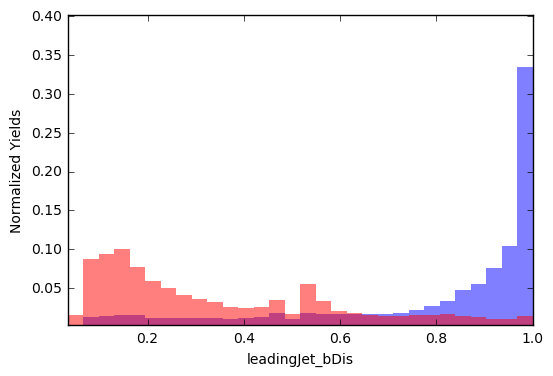

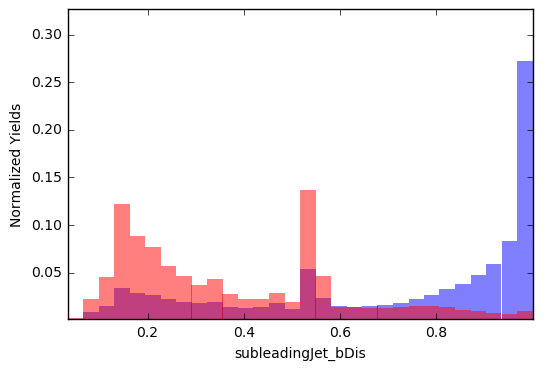

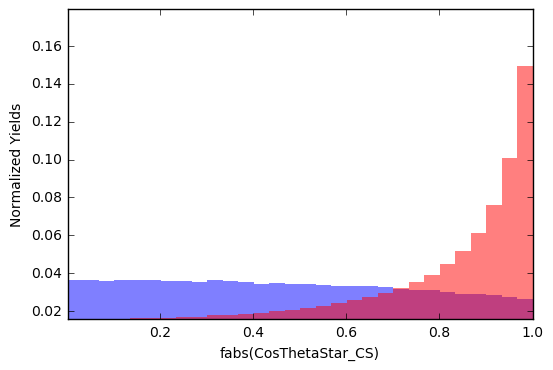

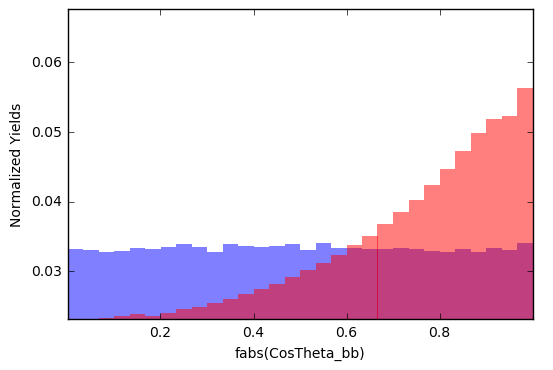

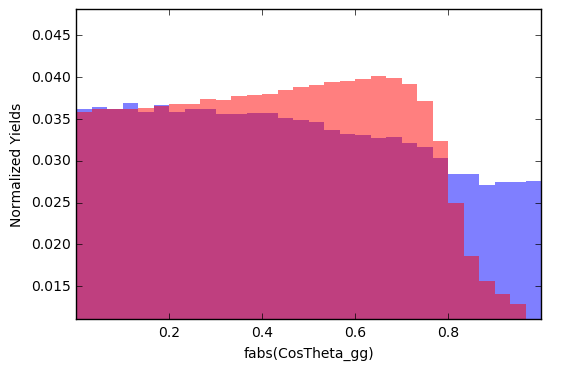

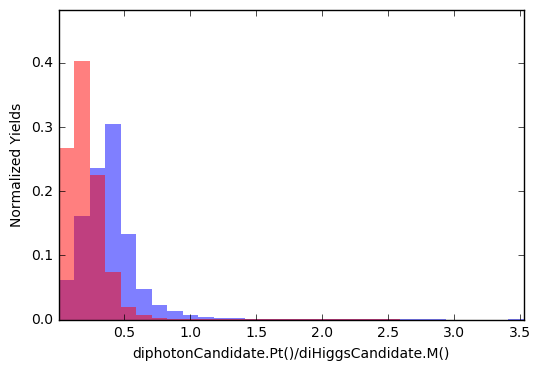

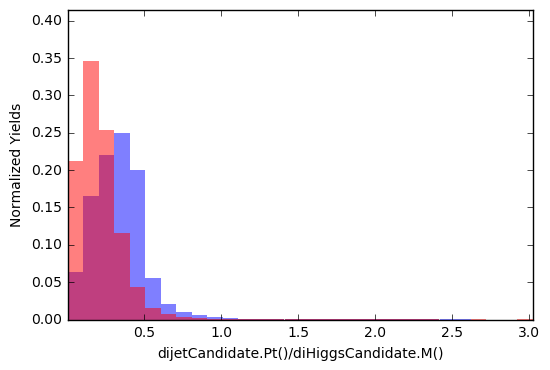

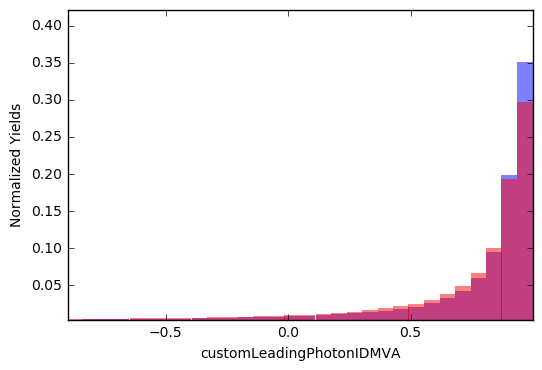

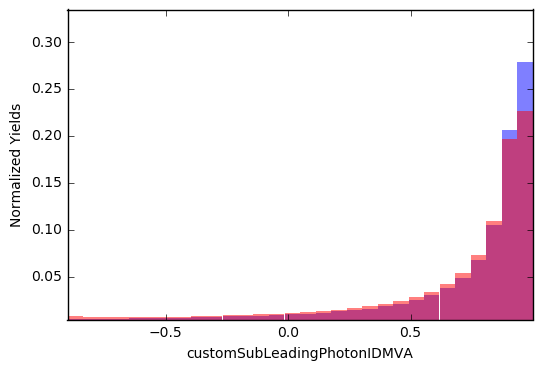

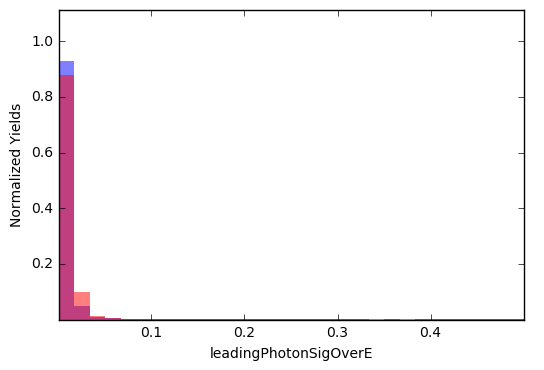

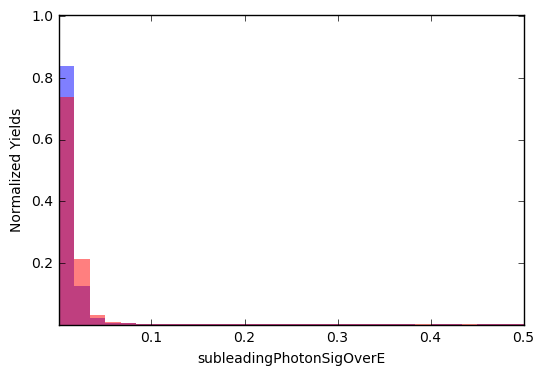

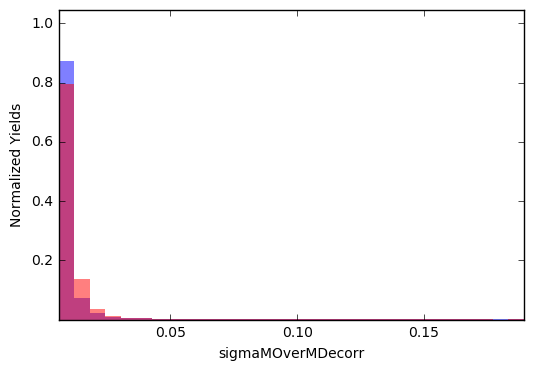

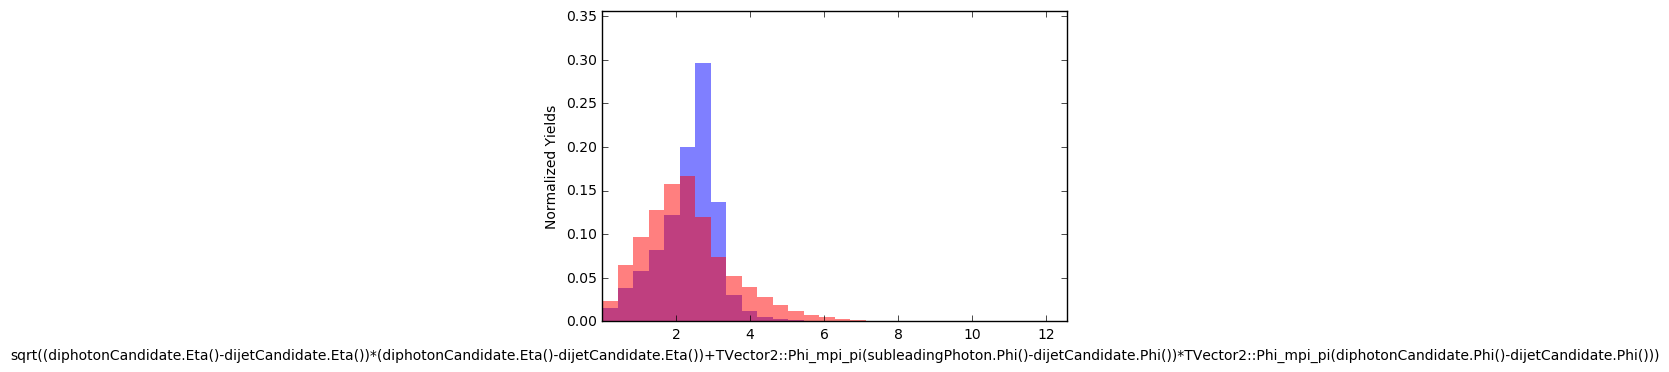

In [175]:
#FIXME, do weighted plots?
utils.plotting.plot_input_variables(X_sig,X_bkg,branch_names)

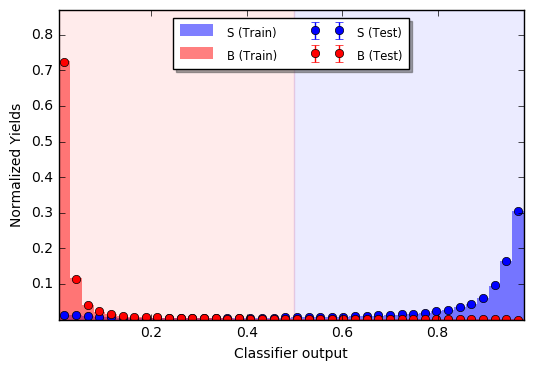

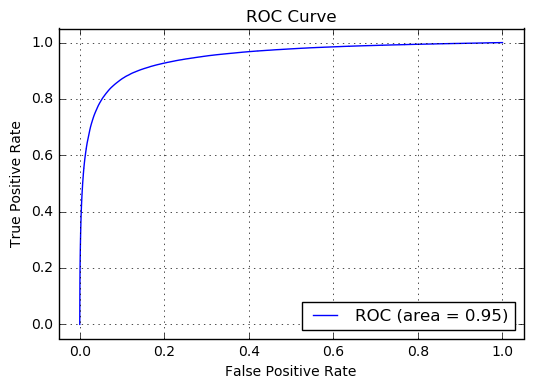

======== ROC report ========
0
1
True positive rate: 0.05
False positive rate:6.83177075062e-05
2
True positive rate: 0.1
False positive rate:0.000208502094337
3
True positive rate: 0.15
False positive rate:0.000408131759128
4
True positive rate: 0.2
False positive rate:0.000700921934154
5
True positive rate: 0.25
False positive rate:0.00113478373897
6
True positive rate: 0.3
False positive rate:0.00174077067698
7
True positive rate: 0.35
False positive rate:0.0024931527025
8
9
True positive rate: 0.45
False positive rate:0.00495525190158
10
True positive rate: 0.5
False positive rate:0.00687169668357
11
True positive rate: 0.55
False positive rate:0.00941009877676
12
True positive rate: 0.6
False positive rate:0.0130894953096
13
True positive rate: 0.65
False positive rate:0.0182594600062
14
True positive rate: 0.7
False positive rate:0.0253387715411
15
True positive rate: 0.75
False positive rate:0.0361001413378
16
True positive rate: 0.8
False positive rate:0.0527288487934
17
True p

In [24]:
import matplotlib.pyplot as plt
reload(utils)

X_total_test = utils.preprocessing.get_total_test_sample(X_sig,X_bkg)
y_total_test = utils.preprocessing.get_total_test_sample(y_sig,y_bkg).ravel()

utils.plotting.plot_classifier_output(clf,X_total_train,X_total_test,y_total_train,y_total_test,outString="xbrg")
plt.show()
fpr,tpr=utils.plotting.plot_roc_curve_multiclass(X_total_test,y_total_test,clf,outString="xgbr")
plt.show()
utils.plotting.print_roc_report(fpr,tpr,step=0.05)

[ 0.21439976  0.08243091  0.0485385  ...,  0.11997221  0.52134252
  0.23503737]


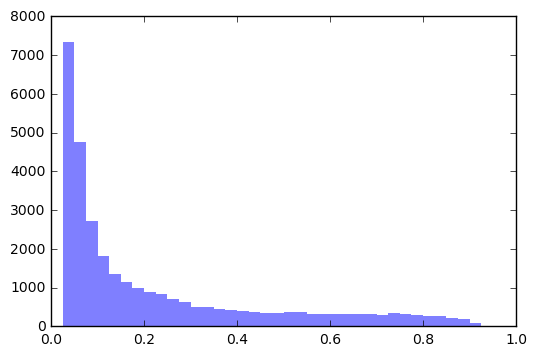

In [177]:
bkg_train = X_total_train[y_total_train == -2]
print clf.predict_proba(bkg_train)[:,1] 
Y_pred_bkg_train = clf.predict_proba(bkg_train)[:,1]

Histo_training_S = np.histogram(Y_pred_bkg_train,bins=40,range=(0,1))
ax1 = plt.subplot(111)

bin_edges = Histo_training_S[1]
bin_centers = ( bin_edges[:-1] + bin_edges[1:]  ) /2.
bin_widths = (bin_edges[1:] - bin_edges[:-1])


ax1.bar(bin_centers-bin_widths/2.,Histo_training_S[0],facecolor='blue',linewidth=0,width=bin_widths,label='S (Train)',alpha=0.5)
plt.show()

[ 0.18688053  0.71260482  0.9254747  ...,  0.3098349   0.88054991
  0.59497428]


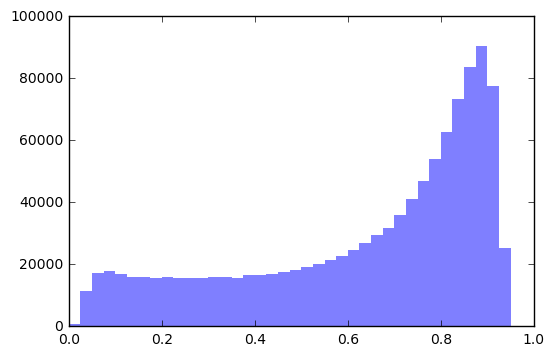

In [28]:
bkg_train = X_total_train[y_total_train == -1]
print clf.predict_proba(bkg_train)[:,1] 
Y_pred_bkg_train = clf.predict_proba(bkg_train)[:,1]

Histo_training_S = np.histogram(Y_pred_bkg_train,bins=40,range=(0,1))
ax1 = plt.subplot(111)

bin_edges = Histo_training_S[1]
bin_centers = ( bin_edges[:-1] + bin_edges[1:]  ) /2.
bin_widths = (bin_edges[1:] - bin_edges[:-1])


ax1.bar(bin_centers-bin_widths/2.,Histo_training_S[0],facecolor='blue',linewidth=0,width=bin_widths,label='S (Train)',alpha=0.5)
plt.show()

[ 0.85980469  0.96765757  0.97392488 ...,  0.03153832  0.95698172
  0.95578295]


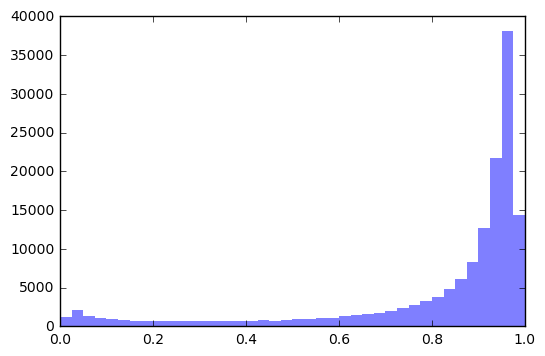

In [29]:
sig_train = X_total_train[y_total_train == 1]
print clf.predict_proba(sig_train)[:,2] 
Y_pred_sig_train = clf.predict_proba(sig_train)[:,2]

Histo_training_S = np.histogram(Y_pred_sig_train,bins=40,range=(0,1))
ax1 = plt.subplot(111)

bin_edges = Histo_training_S[1]
bin_centers = ( bin_edges[:-1] + bin_edges[1:]  ) /2.
bin_widths = (bin_edges[1:] - bin_edges[:-1])


ax1.bar(bin_centers-bin_widths/2.,Histo_training_S[0],facecolor='blue',linewidth=0,width=bin_widths,label='S (Train)',alpha=0.5)
plt.show()

In [43]:
from sklearn.externals import joblib
joblib.dump(clf, os.path.expanduser('~/HHbbgg_ETH/Training/output_files/allMC.pkl'), compress=9)

['/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/Training/output_files/allMC.pkl']